In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(
    "dsc_demo.csv", skiprows=2, names=["Time", "Temp", "HeatFlow", "HeatFlowDerivative"]
)
df

,Time,Temp,HeatFlow,HeatFlowDerivative
0,17.001667,-38.684254,-212.316841,7.472534
1,17.010000,-38.684277,-212.557808,3.025269
2,17.018333,-38.684341,-212.721077,-4.092407
3,17.026667,-38.684319,-212.830513,-14.139404
4,17.035000,-38.684170,-212.761696,-29.698608
...,...,...,...,...
11755,114.960000,218.264633,-1582.107735,-14.784668
11756,114.968333,218.341126,-1581.991280,-13.694824
11757,114.976667,218.409500,-1581.880196,-12.676758
11758,114.985000,218.469788,-1581.805855,-11.868164


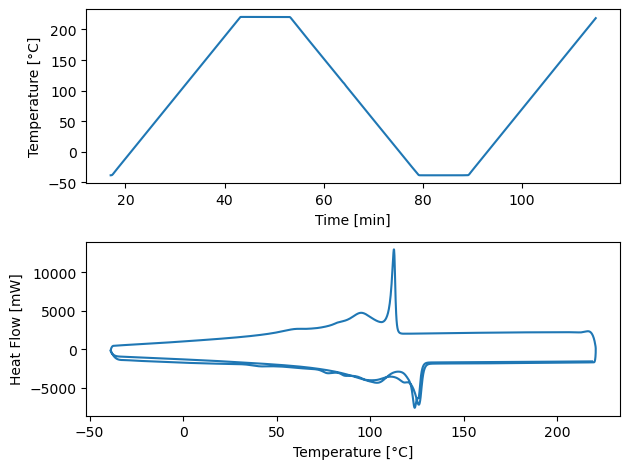

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

ax[0].plot(df["Time"], df["Temp"])
ax[0].set_xlabel("Time [min]")
ax[0].set_ylabel("Temperature [°C]")

ax[1].plot(df["Temp"], df["HeatFlow"])
ax[1].set_xlabel("Temperature [°C]")
ax[1].set_ylabel("Heat Flow [mW]")

fig.tight_layout()

Text(0, 0.5, 'dT/dt [°C/min]')

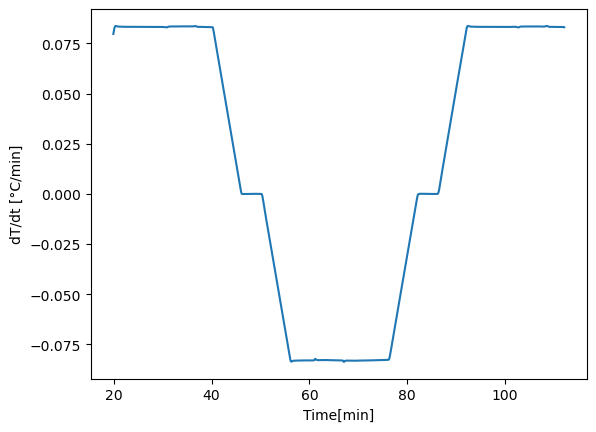

In [4]:
df = df.sort_values("Time")
df["Temp_smooth"] = df["Temp"].rolling(window=700, center=True).mean()
df["dT"] = df["Temp_smooth"].diff()
plt.plot(df["Time"], df["dT"])
plt.xlabel("Time[min]")
plt.ylabel("dT/dt [°C/min]")

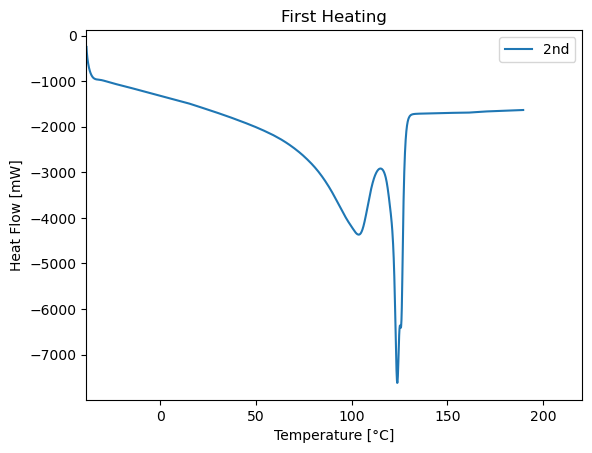

In [5]:
df_heating = df[(df["dT"] > 0.01)]
index_diff = df_heating.index.to_series().diff().fillna(1)
block_boundaries = index_diff[index_diff != 1].index
second_begin_index = df_heating.index.get_loc(block_boundaries[-1])

first_heating = df_heating.iloc[:second_begin_index].copy()
second_heating = df_heating.iloc[second_begin_index:].copy()


fig, ax = plt.subplots()
# ax.plot(first_heating["Temp"], first_heating["HeatFlow"], label="1st")
ax.plot(second_heating["Temp"], second_heating["HeatFlow"], label="2nd")
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Heat Flow [mW]")
ax.set_title("First Heating")
ax.set_xlim(df["Temp"].min(), df["Temp"].max())
ax.legend()

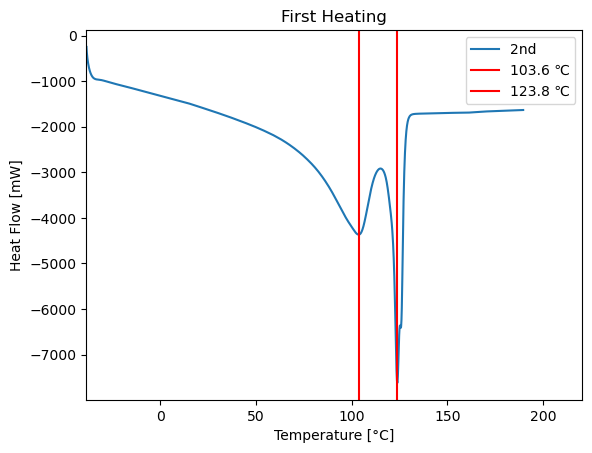

In [6]:
from scipy.signal import find_peaks, savgol_filter

window_length = 50
polyorder = 3
second_heating.loc[:, "HeatFlow_smooth"] = savgol_filter(
    second_heating["HeatFlow"], window_length, polyorder
)
second_heating.loc[:, "HeatFlow_smooth"] *= -1
peaks, properties = find_peaks(second_heating["HeatFlow_smooth"], prominence=50)
peak_temperatures = second_heating["Temp"].iloc[peaks]

fig, ax = plt.subplots()
ax.plot(second_heating["Temp"], second_heating["HeatFlow"], label="2nd")
for temp in peak_temperatures:
    ax.axvline(x=temp, color="red", label=f"{temp:.1f} ℃")
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Heat Flow [mW]")
ax.set_title("First Heating")
ax.set_xlim(df["Temp"].min(), df["Temp"].max())
ax.legend()

In [7]:
peak_temperatures

10379    103.585312
10624    123.841331
Name: Temp, dtype: float64

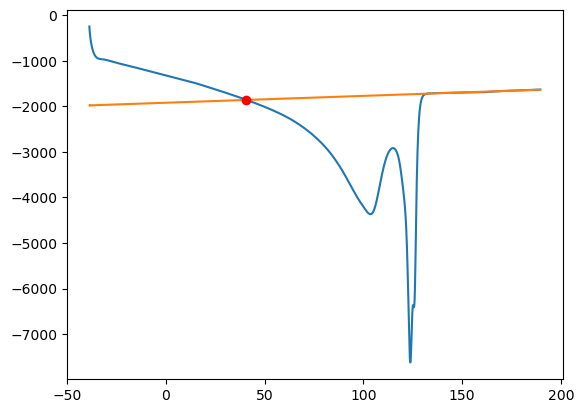

In [8]:
import numpy as np

fit_target = second_heating[
    second_heating["Temp"] > peak_temperatures.values[-1]
].copy()
df["HeatFlow_smooth"] = df["HeatFlow"].rolling(window=700, center=True).mean()
fit_target["dHF/dT"] = (
    fit_target["HeatFlow_smooth"].diff() / fit_target["Temp_smooth"].diff()
)
fit_target["isFlat"] = fit_target["dHF/dT"].abs() < 10
a, b = np.polyfit(
    fit_target.loc[fit_target["isFlat"], "Temp"],
    fit_target.loc[fit_target["isFlat"], "HeatFlow"],
    1,
)

fig, ax = plt.subplots()
ax.plot(second_heating["Temp"], second_heating["HeatFlow"], label="2nd")
ax.plot(second_heating["Temp"], a * second_heating["Temp"] + b, label="Linear Fit")

diff = second_heating["HeatFlow"] - (a * second_heating["Temp"] + b)

sign_change_indices = np.where(np.diff(np.sign(diff)) != 0)[0]

for idx in sign_change_indices[::-1]:
    if second_heating["Temp"].iloc[idx] < peak_temperatures.values[0]:
        intersection_index = idx
        break
ax.plot(
    second_heating["Temp"].iloc[intersection_index],
    second_heating["HeatFlow"].iloc[intersection_index],
    "ro",
)

In [9]:
from typing import List, Union, Dict


def find_peak_temp(
    csv_file: str,
    window_length: int = 50,
    polyorder: int = 3,
    prominence: int = 50,
    temp_window: int = 700,
    dT_threshold: float = 0.01,
    linear_fit_threshold: int = 10,
) -> Dict[str, Union[List[float], float]]:
    df = pd.read_csv(
        csv_file, skiprows=2, names=["Time", "Temp", "HeatFlow", "HeatFlowDerivative"]
    )
    df = df.sort_values("Time")
    df["Temp_smooth"] = df["Temp"].rolling(window=temp_window, center=True).mean()
    df["dT"] = df["Temp_smooth"].diff()
    df_heating = df[(df["dT"] > dT_threshold)]
    index_diff = df_heating.index.to_series().diff().fillna(1)
    block_boundaries = index_diff[index_diff != 1].index
    second_begin_index = df_heating.index.get_loc(block_boundaries[-1])
    second_heating = df_heating.iloc[second_begin_index:].copy()

    second_heating.loc[:, "HeatFlow_smooth"] = savgol_filter(
        second_heating["HeatFlow"], window_length, polyorder
    )
    second_heating.loc[:, "HeatFlow_smooth"] *= -1
    peaks, _ = find_peaks(second_heating["HeatFlow_smooth"], prominence=prominence)
    peak_temperatures = second_heating["Temp"].iloc[peaks].values

    fit_target = second_heating[second_heating["Temp"] > peak_temperatures[-1]].copy()
    df["HeatFlow_smooth"] = (
        df["HeatFlow"].rolling(window=temp_window, center=True).mean()
    )
    fit_target["dHF/dT"] = (
        fit_target["HeatFlow_smooth"].diff() / fit_target["Temp_smooth"].diff()
    )
    fit_target["isFlat"] = fit_target["dHF/dT"].abs() < linear_fit_threshold
    a, b = np.polyfit(
        fit_target.loc[fit_target["isFlat"], "Temp"],
        fit_target.loc[fit_target["isFlat"], "HeatFlow"],
        1,
    )

    diff = second_heating["HeatFlow"] - (a * second_heating["Temp"] + b)

    sign_change_indices = np.where(np.diff(np.sign(diff)) != 0)[0]

    for idx in sign_change_indices[::-1]:
        if second_heating["Temp"].iloc[idx] < peak_temperatures[0]:
            intersection_index = idx
            break
    return {
        "peak_temps": peak_temperatures.tolist(),
        "stert_temp": second_heating["Temp"].iloc[intersection_index],
    }

In [10]:
find_peak_temp("dsc_demo.csv")

{'peak_temps': [103.5853119, 123.8413315], 'stert_temp': 40.80500031}